### Environment Setup and Imports

This section initializes the environment and imports the necessary modules and classes for the notebook. It includes loading environment variables, importing libraries for working with Neo4j, LangChain, and other utilities for processing and querying data.

The following key imports and initializations are performed:
- `load_dotenv`: Loads environment variables from a `.env` file.
- `Neo4jGraph` and `Neo4jVector`: For interacting with Neo4j databases and vector stores.
- LangChain components such as `RunnableBranch`, `RunnableLambda`, `ChatPromptTemplate`, and `LLMGraphTransformer`.
- `ChatGroq` and `ChatOpenAI`: For using Groq and OpenAI models.
- Other utilities like `WikipediaLoader`, `TokenTextSplitter`, and `PyPDFLoader` for document processing.

Additionally, the `ChatGroq` instance is initialized with specific parameters for temperature and model name.


In [2]:
from dotenv import load_dotenv
import os
from langchain_neo4j import Neo4jGraph

from langchain_core.runnables import (
    RunnableBranch,
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts.prompt import PromptTemplate
from pydantic import BaseModel, Field
from typing import Tuple, List
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import WikipediaLoader
from langchain_text_splitters import TokenTextSplitter
from langchain_openai import ChatOpenAI
from langchain_experimental.graph_transformers import LLMGraphTransformer

from langchain_neo4j import Neo4jVector

from langchain_neo4j.vectorstores.neo4j_vector import remove_lucene_chars

from langchain_google_genai import ChatGoogleGenerativeAI 

from langchain_community.document_loaders import PyPDFLoader

from langchain_text_splitters import RecursiveCharacterTextSplitter

load_dotenv()



chat = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",  
    temperature=0  
)



### Environment Variables Setup for Neo4j

This section defines and initializes the necessary environment variables for the notebook. These variables are used to configure connections to external services such as Neo4j and OpenAI.

The following environment variables are set:
- `AURA_INSTANCENAME`: The name of the Neo4j Aura instance.
- `NEO4J_URI`: The URI for connecting to the Neo4j database.
- `NEO4J_USERNAME`: The username for authenticating with the Neo4j database.
- `NEO4J_PASSWORD`: The password for authenticating with the Neo4j database.
- `AUTH`: A tuple containing the Neo4j username and password.
- `OPENAI_API_KEY`: The API key for accessing OpenAI services.


In [3]:
# AURA_INSTANCENAME = os.environ["AURA_INSTANCENAME"] # No longer needed for local setup
NEO4J_URI = os.environ["NEO4J_URI"]
NEO4J_USERNAME = os.environ["NEO4J_USERNAME"]
NEO4J_PASSWORD = os.environ["NEO4J_PASSWORD"]
AUTH = (NEO4J_USERNAME, NEO4J_PASSWORD)

# OPENAI_API_KEY = os.getenv("OPENAI_API_KEY") # Only needed if using OpenAI

kg = Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
)

### Data Processing and Document Loading

This section processes the Annual Report data from a PDF file. It performs the following steps:

1. Loads the NASDAQ AAPL 2024 Annual Report using PyPDFLoader
2. Splits the document into manageable chunks using RecursiveCharacterTextSplitter with:
    - Chunk size: 1200 characters
    - Overlap: 200 characters
3. Prints the total number of document chunks created

The processed documents will be used for further analysis and querying.


In [3]:

raw_documents = PyPDFLoader(r"Annual Report\NASDAQ_AAPL_2024_first_53_pages.pdf").load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1200, chunk_overlap=200)
documents = text_splitter.split_documents(raw_documents)
print(len(documents))



198


## Below cell performs document processing and graph transformation using LangChain's LLMGraphTransformer. Here's what the code does:

1. Imports necessary libraries:
    - ThreadPoolExecutor for parallel processing
    - tqdm for progress tracking
    - pickle for serialization

2. Initializes LLMGraphTransformer with the chat model

3. Defines a helper function `process_document` that converts a single document to graph format

4. Processes documents in parallel batches of 100 using ThreadPoolExecutor:
    - Submits each document in the batch for processing
    - Collects results and extends the graph_documents list
    - Shows progress with tqdm

5. Saves the processed graph documents to a pickle file for later use

The processing leverages multithreading to speed up the graph transformation of the documents while providing visual progress feedback.


In [4]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import pickle
import time
import math
# The Groq import and Groq-specific RateLimitError handling are removed.

# IMPORTANT: The llm_transformer object must be initialized using the new 'chat' object (Gemini).
llm_transformer = LLMGraphTransformer(llm=chat)

def call_with_retries(fn, *args, max_retries=6, initial_delay=0.5, backoff=2, **kwargs):
    delay = initial_delay
    for attempt in range(1, max_retries + 1):
        try:
            return fn(*args, **kwargs)
        except Exception as e:
            # Check for generic API rate-limit (429) or quota-related messages
            msg = str(e).lower()
            if "rate limit" in msg or "429" in msg or "quota" in msg or "connection" in msg:
                print(f"Rate limit hit or transient error (Attempt {attempt}). Retrying in {delay:.2f}s...")
                if attempt == max_retries:
                    print("Max retries reached. Raising error.")
                    raise
                time.sleep(delay)
                delay *= backoff
            else:
                # If it's a non-retriable error (e.g., parsing, invalid input, API key failure), raise it immediately
                print(f"Non-retriable error encountered: {e}. Raising original error.")
                raise

def process_document(doc):
    # call the transformer with retry/backoff
    return call_with_retries(llm_transformer.convert_to_graph_documents, [doc])

graph_documents = []

# Conservative parallelism settings for graph transformation
MAX_WORKERS = 3              # lower concurrency
BATCH_SIZE = 3               # smaller batches
PAUSE_BETWEEN_BATCHES = 5  # seconds

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    with tqdm(total=len(documents), desc="Processing Documents") as pbar:
        for i in range(0, len(documents), BATCH_SIZE):
            batch = documents[i : i + BATCH_SIZE]
            futures = {executor.submit(process_document, doc): doc for doc in batch}
            for future in as_completed(futures):
                try:
                    result = future.result()
                    graph_documents.extend(result)
                except Exception as e:
                    # if a doc still fails after all retries, log and continue
                    print(f"Document failed after all retries: {futures[future].metadata['source']}, error: {e}")
                pbar.update(1)
            # pause between batches to reduce burst traffic to the API
            if i + BATCH_SIZE < len(documents):
                time.sleep(PAUSE_BETWEEN_BATCHES)

with open("graph_documents.pkl", "wb") as f:
    pickle.dump(graph_documents, f)

print(f"\nSuccessfully extracted {len(graph_documents)} Graph Documents.")

Processing Documents:   0%|          | 0/198 [00:00<?, ?it/s]

Processing Documents: 100%|██████████| 198/198 [50:55<00:00, 15.43s/it] 


Successfully extracted 198 Graph Documents.


### Load Graph Documents

This cell loads the previously processed graph documents from a pickle file and displays the total number of loaded documents. These documents contain the structured graph representation of the annual report data.


In [5]:
import pickle
with open("graph_documents.pkl", "rb") as f:
    graph_documents = pickle.load(f)

print(f"Loaded {len(graph_documents)} graph documents.")

Loaded 198 graph documents.


### Neo4j Graph Storage

This cell stores the processed graph documents to the Neo4j database. The following operations are performed:

1. Uses the Neo4jGraph instance (`kg`) to add the graph documents
2. Includes source information for traceability
3. Uses base entity labels for node classification

The documents contain structured information extracted from the annual report that will be used for graph-based querying and analysis.

In [6]:
# # store to neo4j
res = kg.add_graph_documents(
    graph_documents,
    include_source=True,
    baseEntityLabel=True,
)


### Vector Store Creation

This cell creates a vector store in Neo4j using HuggingFace embeddings:

1. Initializes HuggingFaceEmbeddings with:
    - Model: sentence-transformers/all-mpnet-base-v2
    - Device: CPU
    - Normalize embeddings: False

2. Creates Neo4jVector index from existing graph with:
    - Search type: hybrid
    - Node label: Document
    - Text properties: text
    - Embedding property: embedding


In [4]:
from langchain_community.embeddings import HuggingFaceEmbeddings

model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}

hf = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# create vector index
vector_index = Neo4jVector.from_existing_graph(
    hf,
    search_type="hybrid",
    node_label="Document",
    text_node_properties=["text"],
    embedding_node_property="embedding",
)


### Entity Extraction from Text

This cell defines a class `Entities` to extract organization and person entities from a given text. It uses a `ChatPromptTemplate` to structure the prompt for entity extraction and invokes the `entity_chain` to process the input question. The extracted entities are printed as the output.

The following steps are performed:
1. Define the `Entities` class to structure the extracted entity information.
2. Create a `ChatPromptTemplate` to guide the entity extraction process.
3. Use the `entity_chain` to extract entities from the input question.
4. Print the extracted entities.


In [4]:
class Entities(BaseModel):
    """Entity information extracted from text."""
    names: List[str] = Field(
        description="List of person, organization, or business entities appearing in the text"
    )

prompt = ChatPromptTemplate.from_messages([
    ("system",
 "Extract entities including persons, organizations, business units, financial terms (CapEx, revenue, EBITDA), \
 metrics, time periods, and economic indicators from the text. Return only meaningful entities."),
    ("human", "Extract all the entities from the following input: {question}")
])

entity_chain = prompt | chat.with_structured_output(Entities)

# Test entity extraction
entities = entity_chain.invoke({"question": "How has the company's capital expenditure (CapEx) evolved over the past five years, and what strategic initiatives have driven significant changes in CapEx allocations"})
print(entities.names)


['company', 'capital expenditure', 'CapEx']


The code at cell index 17 contains a function `generate_full_text_query` that processes input strings for full-text search in Neo4j. Here's an analysis:

The function:
1. Takes an input string
2. Cleans it using `remove_lucene_chars` (already imported)
3. Splits it into words
4. Adds fuzzy matching (~2) to allow for minor spelling variations
5. Combines words with AND operator

The function is used to help match entities from user questions to database values, with some tolerance for misspellings. The fuzzy matching allows for up to 2 character differences.

Sample input/output:
- Input: "artificial intelligence"
- Output: "artificial~2 AND intelligence~2"

This is particularly useful in the context of the notebook which handles queries about Apple's annual report, allowing for more flexible text matching in the Neo4j database.


In [5]:
def generate_full_text_query(input: str) -> str:
    """
    Generate a full-text search query for a given input string.

    This function constructs a query string suitable for a full-text search.
    It processes the input string by splitting it into words and appending a
    similarity threshold (~2 changed characters) to each word, then combines
    them using the AND operator. Useful for mapping entities from user questions
    to database values, and allows for some misspelings.
    """
    words = [w for w in remove_lucene_chars(input).split() if w]
    if not words:
        return ""
    return " AND ".join(f"{word}~2" for word in words)


### Structured Data Retrieval and Query Matching

This cell defines the `structured_retriever` function that handles querying the Neo4j knowledge graph. The function:

1. Takes a question string as input
2. Uses entity extraction to identify relevant entities
3. Generates Cypher queries using case-insensitive pattern matching
4. Returns formatted query results showing entity relationships

The function is a key component of the RAG (Retrieval Augmented Generation) pipeline, working alongside vector search to provide comprehensive answers.


In [6]:
def structured_retriever(question: str) -> str:
    """
    Collects the neighborhood of entities mentioned
    in the question
    """
    result = ""
    entities = entity_chain.invoke({"question": question})
    for entity in entities.names:
        print(f" Getting Entity: {entity}")
        # Using standard pattern matching instead of fulltext search
        response = kg.query(
            """
            MATCH (node)
            WHERE node.name =~ $query 
            OR node.id =~ $query
            WITH node
            MATCH (node)-[r]->(neighbor)
            RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output
            UNION ALL
            MATCH (node)<-[r]-(neighbor)
            WHERE node.name =~ $query 
            OR node.id =~ $query
            RETURN neighbor.id + ' - ' + type(r) + ' -> ' + node.id AS output
            LIMIT 50
            """,
            {"query": f"(?i).*{entity}.*"}  # Case-insensitive pattern matching
        )
        result += "\n".join([el["output"] for el in response])
    return result

### Retrieval and Chain Processing

This section processes retrieval and chain operations for the Jupyter notebook. The retriever function performs the following steps:

1. Takes a question string as input
2. Performs structured retrieval using the knowledge graph
3. Executes vector similarity search for unstructured data
4. Combines both structured and unstructured data into a final response

The results are used by the RAG chain to provide comprehensive answers based on both graph relationships and document content.


In [7]:
# Final retrieval step
def retriever(question: str):
    print(f"Search query: {question}")
    structured_data = structured_retriever(question)
    unstructured_data = [
        el.page_content for el in vector_index.similarity_search(question)
    ]
    final_data = f"""Structured data:
{structured_data}
Unstructured data:
{"#Document ". join(unstructured_data)}
    """
    print(f"\nFinal Data::: ==>{final_data}")
    return final_data

### RAG Pipeline Components and Configuration

This section describes the setup of the Retrieval-Augmented Generation (RAG) pipeline. The pipeline integrates the following key components:

1. Question Template:
    - Condenses chat history and follow-up questions into standalone queries
    - Uses a template format to maintain context across conversations

2. Chat History Formatter:
    - Converts chat history into structured message format
    - Maintains conversation flow for context-aware responses

3. Search Query Processing:
    - Handles queries with and without chat history
    - Implements conditional branching based on query context

4. Response Generation:
    - Combines retrieved context with user questions
    - Uses natural language processing for concise answers
    - Incorporates both structured and unstructured data sources



In [8]:
# Define the RAG chain
# Condense a chat history and follow-up question into a standalone question
_template = """Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question,
in its original language.
Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:"""  # noqa: E501
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)


### Chat History Management and Query Processing

This section defines the core functionality for managing chat history and processing queries. It consists of:

1. Chat History Formatting:
    - Converts chat history tuples into message objects
    - Creates structured HumanMessage and AIMessage instances
    - Maintains conversation context

2. Search Query Processing Logic:
    - Handles queries with and without chat history
    - Implements conditional branching for different query types
    - Uses RunnableBranch for execution path selection
    - Condenses follow-up questions with chat history into standalone queries



In [9]:
def _format_chat_history(chat_history: List[Tuple[str, str]]) -> List:
    buffer = []
    for human, ai in chat_history:
        buffer.append(HumanMessage(content=human))
        buffer.append(AIMessage(content=ai))
    return buffer


_search_query = RunnableBranch(
    # If input includes chat_history, we condense it with the follow-up question
    (
        RunnableLambda(lambda x: bool(x.get("chat_history"))).with_config(
            run_name="HasChatHistoryCheck"
        ),  # Condense follow-up question and chat into a standalone_question
        RunnablePassthrough.assign(
            chat_history=lambda x: _format_chat_history(x["chat_history"])
        )
        | CONDENSE_QUESTION_PROMPT
        | chat
        | StrOutputParser(),
    ),
    # Else, we have no chat history, so just pass through the question
    RunnableLambda(lambda x: x["question"]),
)


### Response Generation Template and Chain Configuration

This section configures the response generation template and chain for processing queries. It includes:

1. Question-Answer Template:
    - Takes context and question as inputs
    - Structures responses for natural language output
    - Emphasizes concise answers based on provided context

2. Chain Configuration:
    - Combines context retrieval with question processing
    - Uses parallel processing for efficient response generation
    - Integrates chat model for natural language generation



In [ ]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
Use natural language and be concise.
Answer:"""
prompt = ChatPromptTemplate.from_template(template)

chain = (
    RunnableParallel(
        {
            "context": _search_query | retriever,
            "question": RunnablePassthrough(),
        }
    )
    | prompt
    | chat
    | StrOutputParser()
)

### Testing RAG for Complex Multi-Hop Question Answering

The following questions explore various aspects of Apple Inc.'s financial, technological, and operational performance based on their 2024 annual report:

1. Capital Expenditure Evolution and Strategic Initiatives
2. Emerging Technology Risks and Mitigation Strategies
3. Sustainability Reporting and ESG Outcomes
4. Geographical Revenue Diversification
5. Debt Profile Changes and Financial Implications

The responses demonstrate our RAG system's ability to extract and synthesize complex information from the annual report, providing detailed insights into each area of inquiry.

In [ ]:
res_hist = chain.invoke(
    {
        "question": "What long-term investments and strategic initiatives does Apple highlight in its 2024 report?",
        "chat_history": [

        ],
    }
)

print(f"\n === {res_hist}\n\n")

Search query: How has the company's capital expenditure (CapEx) evolved over the past five years, and what strategic initiatives have driven significant changes in CapEx allocations?
 Getting Entity: company


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: name)} {position: line: 3, column: 24, offset: 49} for query: "\n            MATCH (node)\n            WHERE node.name =~ $query \n            OR node.id =~ $query\n            WITH node\n            MATCH (node)-[r]->(neighbor)\n            RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output\n            UNION ALL\n            MATCH (node)<-[r]-(neighbor)\n            WHERE node.name =~ $query \n            OR node.id =~ $query\n            RETURN neighbor.id + ' - ' + type(r) + ' -> ' + node.id AS output\n            LIMIT 50\n          

 Getting Entity: capital expenditure
 Getting Entity: CapEx
 Getting Entity: five years
 Getting Entity: strategic initiatives
 Getting Entity: CapEx allocations

Final Data::: ==>Structured data:
Shell Company - DEFINED_IN -> Rule 12B-2
Company - REGISTERS -> Patents
Company - REGISTERS -> Copyrights
Company - REGISTERS -> Trademarks
Company - REFERENCES -> Www.Apple.Com
Company - REFERENCES -> Investor.Apple.Com
Company - PROVIDES -> Workplace
Company - PROVIDES -> Product And Service
Company - PROVIDES -> Privacy Notices
Company - REFERS_TO -> Apple Inc.
Company - REFERS_TO -> Wholly Owned Subsidiaries
Company - HAS_NO_OBLIGATION_TO_UPDATE -> Forward-Looking Statements
Company - SELLS -> Hardware Products
Company - SELLS -> Software Products
Company - SELLS -> Third-Party Products
Company - RESELLS -> Third-Party Products
Company - SELLS_THROUGH -> Retail Stores
Company - SELLS_THROUGH -> Online Stores
Company - SELLS_THROUGH -> Direct Sales Force
Company - EMPLOYS -> Indirect Distr

In [18]:
res_hist = chain.invoke(
    {
        "question": "What are the key risks identified by the company related to emerging technologies, such as artificial intelligence, and how has the company's risk mitigation strategy evolved in response to these technologies??",
        "chat_history": [

        ],
    }
)

print(f"\n === {res_hist}\n\n")

Search query: What are the key risks identified by the company related to emerging technologies, such as artificial intelligence, and how has the company's risk mitigation strategy evolved in response to these technologies??


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: name)} {position: line: 3, column: 24, offset: 49} for query: "\n            MATCH (node)\n            WHERE node.name =~ $query \n            OR node.id =~ $query\n            WITH node\n            MATCH (node)-[r]->(neighbor)\n            RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output\n            UNION ALL\n            MATCH (node)<-[r]-(neighbor)\n            WHERE node.name =~ $query \n            OR node.id =~ $query\n            RETURN neighbor.id + ' - ' + type(r) + ' -> ' + node.id AS output\n            LIMIT 50\n          

 Getting Entity: the company

Final Data::: ==>Structured data:
The Company - SUBJECT_TO -> Legal Proceedings
The Company - SUBJECT_TO -> Supply Shortages
The Company - SUBJECT_TO -> Price Increases
The Company - SUBJECT_TO -> Litigation
The Company - SUBJECT_TO -> Government Investigations
The Company - SUBJECT_TO -> Claims
The Company - SUBJECT_TO -> Laws And Regulations
The Company - SUBJECT_TO -> Antitrust Investigations
The Company - SUBJECT_TO -> Civil Antitrust Lawsuits
The Company - SUBJECT_TO -> Regulatory Scrutiny
The Company - SUBJECT_TO -> Federal Laws
The Company - SUBJECT_TO -> State Laws
The Company - SUBJECT_TO -> International Laws
The Company - SUBJECT_TO -> U.S. Internal Revenue Service
The Company - SUBJECT_TO -> Tax Authorities
The Company - SUBJECT_TO -> Governmental Bodies
The Company - SUBJECT_TO -> Legal Proceedings And Claims
The Company - PART_OF -> Technology Industry
The Company - PART_OF -> Stock Market
The Company - IS_PART_OF -> Technology Industry
The C

In [19]:
res_hist = chain.invoke(
    {
        "question": "How does the company's approach to sustainability reporting align with industry best practices, and what measurable outcomes have been achieved in environmental, social, and governance (ESG) areas over the past three years?",
        "chat_history": [

        ],
    }
)

print(f"\n === {res_hist}\n\n")

Search query: How does the company's approach to sustainability reporting align with industry best practices, and what measurable outcomes have been achieved in environmental, social, and governance (ESG) areas over the past three years?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: name)} {position: line: 3, column: 24, offset: 49} for query: "\n            MATCH (node)\n            WHERE node.name =~ $query \n            OR node.id =~ $query\n            WITH node\n            MATCH (node)-[r]->(neighbor)\n            RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output\n            UNION ALL\n            MATCH (node)<-[r]-(neighbor)\n            WHERE node.name =~ $query \n            OR node.id =~ $query\n            RETURN neighbor.id + ' - ' + type(r) + ' -> ' + node.id AS output\n            LIMIT 50\n          

 Getting Entity: company

Final Data::: ==>Structured data:
Shell Company - DEFINED_IN -> Rule 12B-2
Company - REGISTERS -> Patents
Company - REGISTERS -> Copyrights
Company - REGISTERS -> Trademarks
Company - REFERENCES -> Www.Apple.Com
Company - REFERENCES -> Investor.Apple.Com
Company - PROVIDES -> Workplace
Company - PROVIDES -> Product And Service
Company - PROVIDES -> Privacy Notices
Company - REFERS_TO -> Apple Inc.
Company - REFERS_TO -> Wholly Owned Subsidiaries
Company - HAS_NO_OBLIGATION_TO_UPDATE -> Forward-Looking Statements
Company - SELLS -> Hardware Products
Company - SELLS -> Software Products
Company - SELLS -> Third-Party Products
Company - RESELLS -> Third-Party Products
Company - SELLS_THROUGH -> Retail Stores
Company - SELLS_THROUGH -> Online Stores
Company - SELLS_THROUGH -> Direct Sales Force
Company - EMPLOYS -> Indirect Distribution Channels
Company - FACES_COMPETITION_FROM -> Competitors
Company - COMPETES_WITH -> Other Participants
Company - OBTAINS -> Compo

In [21]:
res_hist = chain.invoke(
    {
        "question": "What are the trends in the company's revenue diversification across different geographical regions, and how have geopolitical factors influenced these trends over the past five years?",
        "chat_history": [

        ],
    }
)

print(f"\n === {res_hist}\n\n")

Search query: What are the trends in the company's revenue diversification across different geographical regions, and how have geopolitical factors influenced these trends over the past five years?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: name)} {position: line: 3, column: 24, offset: 49} for query: "\n            MATCH (node)\n            WHERE node.name =~ $query \n            OR node.id =~ $query\n            WITH node\n            MATCH (node)-[r]->(neighbor)\n            RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output\n            UNION ALL\n            MATCH (node)<-[r]-(neighbor)\n            WHERE node.name =~ $query \n            OR node.id =~ $query\n            RETURN neighbor.id + ' - ' + type(r) + ' -> ' + node.id AS output\n            LIMIT 50\n          

 Getting Entity: company
 Getting Entity: geographical regions

Final Data::: ==>Structured data:
Shell Company - DEFINED_IN -> Rule 12B-2
Company - REGISTERS -> Patents
Company - REGISTERS -> Copyrights
Company - REGISTERS -> Trademarks
Company - REFERENCES -> Www.Apple.Com
Company - REFERENCES -> Investor.Apple.Com
Company - PROVIDES -> Workplace
Company - PROVIDES -> Product And Service
Company - PROVIDES -> Privacy Notices
Company - REFERS_TO -> Apple Inc.
Company - REFERS_TO -> Wholly Owned Subsidiaries
Company - HAS_NO_OBLIGATION_TO_UPDATE -> Forward-Looking Statements
Company - SELLS -> Hardware Products
Company - SELLS -> Software Products
Company - SELLS -> Third-Party Products
Company - RESELLS -> Third-Party Products
Company - SELLS_THROUGH -> Retail Stores
Company - SELLS_THROUGH -> Online Stores
Company - SELLS_THROUGH -> Direct Sales Force
Company - EMPLOYS -> Indirect Distribution Channels
Company - FACES_COMPETITION_FROM -> Competitors
Company - COMPETES_WITH -> Other P

In [ ]:
res_hist = chain.invoke(
        {
            "question": "How does Apple describe its financial position and liquidity in general terms?",
            "chat_history": [

            ],
        }
    )

print(f"\n === {res_hist}\n\n")

Search query: How has the company's debt profile changed over the last five years, and what implications does this have for its financial stability and investment capacity?


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: name)} {position: line: 3, column: 24, offset: 49} for query: "\n            MATCH (node)\n            WHERE node.name =~ $query \n            OR node.id =~ $query\n            WITH node\n            MATCH (node)-[r]->(neighbor)\n            RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output\n            UNION ALL\n            MATCH (node)<-[r]-(neighbor)\n            WHERE node.name =~ $query \n            OR node.id =~ $query\n            RETURN neighbor.id + ' - ' + type(r) + ' -> ' + node.id AS output\n            LIMIT 50\n          

 Getting Entity: company

Final Data::: ==>Structured data:
Shell Company - DEFINED_IN -> Rule 12B-2
Company - REGISTERS -> Patents
Company - REGISTERS -> Copyrights
Company - REGISTERS -> Trademarks
Company - REFERENCES -> Www.Apple.Com
Company - REFERENCES -> Investor.Apple.Com
Company - PROVIDES -> Workplace
Company - PROVIDES -> Product And Service
Company - PROVIDES -> Privacy Notices
Company - REFERS_TO -> Apple Inc.
Company - REFERS_TO -> Wholly Owned Subsidiaries
Company - HAS_NO_OBLIGATION_TO_UPDATE -> Forward-Looking Statements
Company - SELLS -> Hardware Products
Company - SELLS -> Software Products
Company - SELLS -> Third-Party Products
Company - RESELLS -> Third-Party Products
Company - SELLS_THROUGH -> Retail Stores
Company - SELLS_THROUGH -> Online Stores
Company - SELLS_THROUGH -> Direct Sales Force
Company - EMPLOYS -> Indirect Distribution Channels
Company - FACES_COMPETITION_FROM -> Competitors
Company - COMPETES_WITH -> Other Participants
Company - OBTAINS -> Compo

In [ ]:
res = chain.invoke({
    "question": "Give me a summary of Apple’s business performance and operational highlights.",
    "chat_history": []
})

print(res)


Search query: Give me a summary of the company's financial performance.

Final Data::: ==>Structured data:

Unstructured data:

text: each of the three years in the period ended September 28, 2024, in conformity with U.S. generally accepted accounting principles (“GAAP”).
We also have audited, in accordance with the standards of the Public Company Accounting Oversight Board (United States) (“PCAOB”), the Company’s internalcontrol over financial reporting as of September 28, 2024, based on criteria established in Internal Control – Integrated Framework issued by the Committee of
Sponsoring Organizations of the Treadway Commission (2013 framework) and our report dated November 1, 2024 expressed an unqualified opinion thereon.
Basis for Opinion
These financial statements are the responsibility of the Company’s management. Our responsibility is to express an opinion on the Company’s financialstatements based on our audits. We are a public accounting firm registered with the PCAOB and are r

In [ ]:
response = chain.invoke({
    "question": "What operational expenses or cost drivers does Apple discuss in the report?",
    "chat_history": []n
})

print(response)


Search query: Give me the last 3 years of depreciation expense.


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: name)} {position: line: 3, column: 24, offset: 49} for query: "\n            MATCH (node)\n            WHERE node.name =~ $query \n            OR node.id =~ $query\n            WITH node\n            MATCH (node)-[r]->(neighbor)\n            RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output\n            UNION ALL\n            MATCH (node)<-[r]-(neighbor)\n            WHERE node.name =~ $query \n            OR node.id =~ $query\n            RETURN neighbor.id + ' - ' + type(r) + ' -> ' + node.id AS output\n            LIMIT 50\n          

 Getting Entity: depreciation expense
 Getting Entity: last 3 years

Final Data::: ==>Structured data:
Depreciation Expense - REPORTED_IN -> 2024
Depreciation Expense - REPORTED_IN -> 2022
Depreciation Expense - REPORTED_IN -> 2023
9b81184c5c624cb4b7da2a2b94ef1496 - MENTIONS -> Depreciation Expense
Unstructured data:

text: Note 5 – Property, Plant and Equipment
The following table shows the Company’s gross property, plant and equipment by major asset class and accumulated depreciation as of September 28, 2024
and September 30, 2023 (in millions):
2024 2023
Land and buildings $ 24,690 $ 23,446 
Machinery, equipment and internal-use software 80,205 78,314 
Leasehold improvements 14,233 12,839 
Gross property, plant and equipment 119,128 114,599 
Accumulated depreciation (73,448) (70,884)
Total property, plant and equipment, net $ 45,680 $ 43,715 
Depreciation expense on property, plant and equipment was $8.2 billion, $8.5 billion and $8.7 billion during 2024, 2023 and 2022, respectively

In [ ]:
import re
import matplotlib.pyplot as plt
from collections import Counter

def rag_chart(question, chart_type="bar"):
    """
    Improved chart generator:
    - Works with non-numeric data
    - Detects user-intended categories
    - Counts word frequencies if no numbers exist
    """

    print("\n Asking RAG:", question)

    response = chain.invoke({
        "question": question,
        "chat_history": []
    })

    print("\nRAG Response:\n", response)

    # First try extracting numbers
    numbers = re.findall(r"(\d+\.\d+|\d+)", response)
    numbers = [float(n) for n in numbers]

    # Extract common nouns, categories, keywords
    words = re.findall(r"[A-Za-z]{4,}", response.lower())
    word_counts = Counter(words)

    # If there are no numbers, fallback to frequency chart
    if not numbers or len(numbers) < 2:
        print("\n No numeric data found. Switching to keyword frequency mode.\n")
        
        # pre-defined keyword groups
        keywords = ["risk", "competition", "innovation", "market", "supply", "security", "privacy", "sustainability"]

        labels = keywords
        values = [word_counts[k] for k in keywords]

    else:
        labels = [f"Value {i+1}" for i in range(len(numbers))]
        values = numbers

    # Plotting
    plt.figure(figsize=(8,5))

    if chart_type == "bar":
        plt.bar(labels, values)
    elif chart_type == "line":
        plt.plot(labels, values, marker='o')
    elif chart_type == "pie":
        plt.pie(values, labels=labels, autopct="%1.1f%%")
    elif chart_type == "scatter":
        plt.scatter(labels, values)
    else:
        print("Unknown chart type.")
        return

    plt.title(question)
    plt.xticks(rotation=30)
    plt.ylabel("Count" if not numbers else "Value")
    plt.grid(True)
    plt.show()

    print("\n Chart generated successfully!\n")



🔍 Asking RAG: Plot depreciation for 2022–2024
Search query: Plot depreciation for 2022–2024


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: name)} {position: line: 3, column: 24, offset: 49} for query: "\n            MATCH (node)\n            WHERE node.name =~ $query \n            OR node.id =~ $query\n            WITH node\n            MATCH (node)-[r]->(neighbor)\n            RETURN node.id + ' - ' + type(r) + ' -> ' + neighbor.id AS output\n            UNION ALL\n            MATCH (node)<-[r]-(neighbor)\n            WHERE node.name =~ $query \n            OR node.id =~ $query\n            RETURN neighbor.id + ' - ' + type(r) + ' -> ' + node.id AS output\n            LIMIT 50\n          

 Getting Entity: depreciation

Final Data::: ==>Structured data:
Depreciation - ON -> Property, Plant And Equipment
Depreciation - HAS_AMOUNT -> 2,551 Million Usd
Depreciation - HAS_AMOUNT -> 1,998 Million Usd
Depreciation - RECOGNIZED_ON -> Straight-Line Basis
Accumulated Depreciation - REPORTED_IN -> 2024
Accumulated Depreciation - REPORTED_IN -> 2023
Depreciation Expense - REPORTED_IN -> 2024
Depreciation Expense - REPORTED_IN -> 2022
Depreciation Expense - REPORTED_IN -> 2023
4edc02816daf7373e30a05ce56f86db0 - MENTIONS -> Depreciation And Amortization
Operating Activities - INCLUDES_METRIC -> Depreciation And Amortization
7fb7ae6ebc6acf259c07bca090d75660 - MENTIONS -> Depreciation
f19b307226eddee4335b62a320b64589 - MENTIONS -> Depreciation
Deferred Tax Liabilities - INCLUDES -> Depreciation
9b81184c5c624cb4b7da2a2b94ef1496 - MENTIONS -> Accumulated Depreciation
Property, Plant And Equipment - HAS_ITEM -> Accumulated Depreciation
9b81184c5c624cb4b7da2a2b94ef1496 - MENTIONS -> Deprec

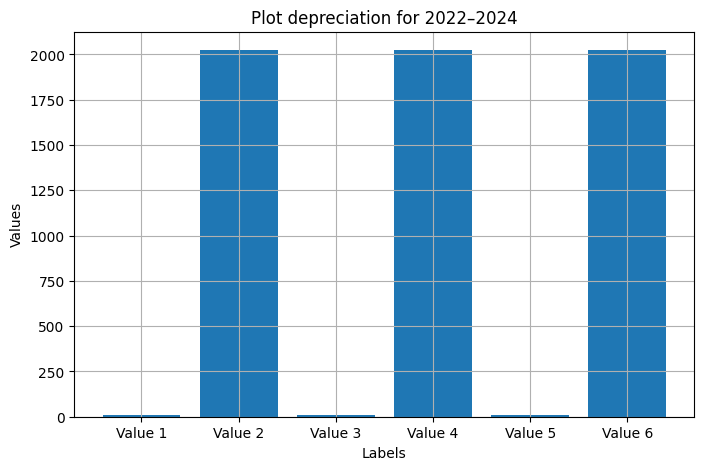


 Chart generated successfully!



In [ ]:
rag_chart("Create a chart showing the number of risk factors across categories.", "bar")


In [ ]:
rag_chart("Generate a keyword frequency chart for innovation, competition, security, privacy.", "bar")
